# Hands-On SARIMA & SARIMAX
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-advanced-dl/blob/main/Unidad%201%20-%20Time%20Series/sarima-sarimax.ipynb)

En este notebook se trabajarán ejemplos prácticos de los modelos SARIMA y SARIMAX vistos en la lectura teórica, dando cierre a la sección de modelos clásicos para series de tiempo de esta unidad. Estos añaden complejidades al modelo base ARIMA que les permiten trabajar con series que exhiben patrones estacionales y además incorporar información exógena para realizar las predicciones.

En este caso, vamos a trabajar con datasets reales, aunque ya curados, para ya empezar a poner en práctica y observar las diferencias en rendimiento de los modelos. Vamos a usar el dataset de ventas de Adidas.

In [3]:
import pkg_resources

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

In [4]:
!test '{IN_COLAB}' = 'True' && wget  https://github.com/Ohtar10/icesi-advanced-dl/raw/main/requirements.txt  && pip install -r requirements.txt

In [48]:
!test '{IN_COLAB}' = 'True' && mkdir -p datasets/ && wget https://github.com/Ohtar10/icesi-advanced-dl/raw/main/datasets/jj.csv -O datasets/jj.csv

In [73]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns

np.random.seed(1234)

if IN_COLAB:
  dataset_path = './datasets/adidas_revenue1.csv'
else:
  dataset_path = '../datasets/adidas_revenue1.csv'

dataset = pd.read_csv(dataset_path)
dataset.head(20)

,date,Revenue,US GDP,Europe GDP,CHN GDP US,Price Index,NIKE
0,2000Q1,1517,12359.095,1728.2440,257.649148,246.5,2161.6000
1,2000Q2,1248,12592.530,1749.6000,290.437535,326.4,2272.7000
2,2000Q3,1677,12607.676,1769.2586,310.550979,322.5,2636.7000
3,2000Q4,1393,12679.338,1789.2533,352.695291,321.0,2198.7000
4,2001Q1,1558,12643.283,1819.1398,290.974546,329.4,2170.1000
5,2001Q2,1368,12710.303,1833.7128,322.918555,329.8,2483.3000
6,2001Q3,1790,12670.106,1845.8787,342.318287,313.3,2613.7000
7,2001Q4,1396,12705.269,1861.9357,383.203654,302.1,2336.8000
8,2002Q1,1638,12822.258,1878.7827,317.672216,296.5,2260.3000
9,2002Q2,1507,12893.002,1893.8006,352.720156,301.0,2682.2000


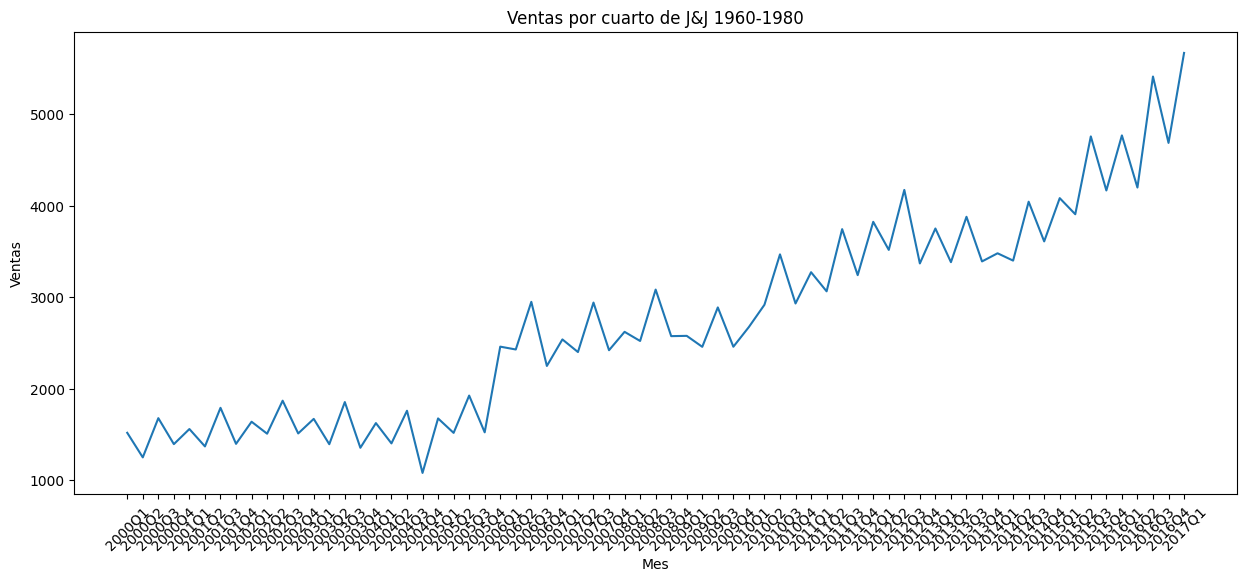

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(dataset['date'], dataset['Revenue'], label='Ventas')
ax.set_xlabel("Mes")
ax.set_ylabel("Ventas")
ax.tick_params(axis='x', labelrotation=45)
plt.title("Ventas por cuarto de J&J 1960-1980")
plt.show()

Como podemos observar, tenemos una serie que exhibe tendencia. Intentemos observar el ACF y PACF

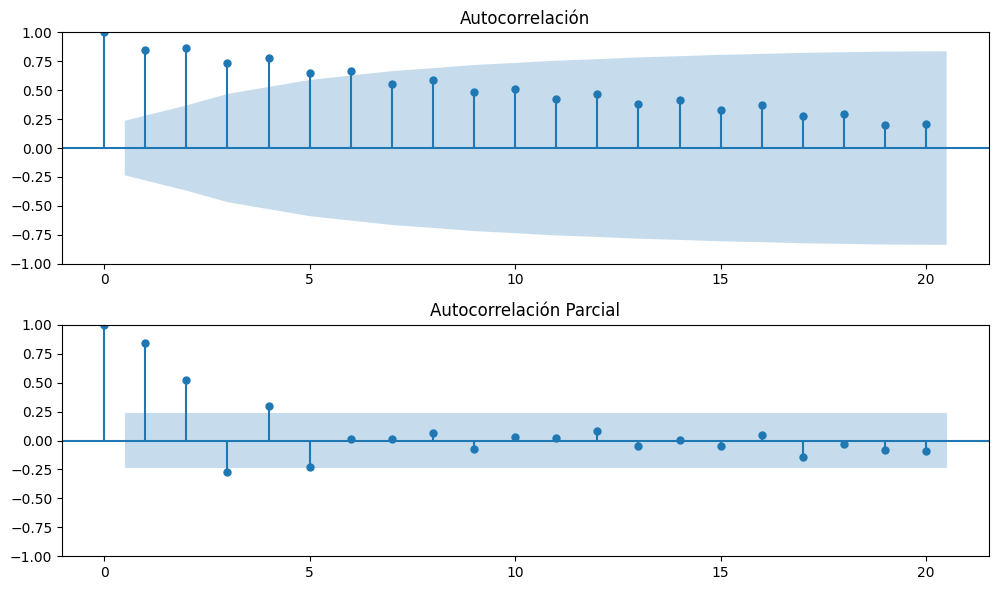

In [75]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
plot_acf(dataset['Revenue'], lags=20, title="Autocorrelación", ax=ax1)
plot_pacf(dataset['Revenue'], lags=20, title="Autocorrelación Parcial", ax=ax2)
plt.tight_layout()
plt.show()

De diagrama ACF pareciera que hay un fuerte componente MA, y que inclusto hasta el lag 6 es significativo. Por el contrario, el componente de autocorrelación oscila. Parece que estamos ante una serie casi estrictamente MA. Pero realicemos las pruebas correspondientes.

Sabemos que la serie no es estacionaria porque tiene una tendencia, ahora intentemos remover la tendencia.

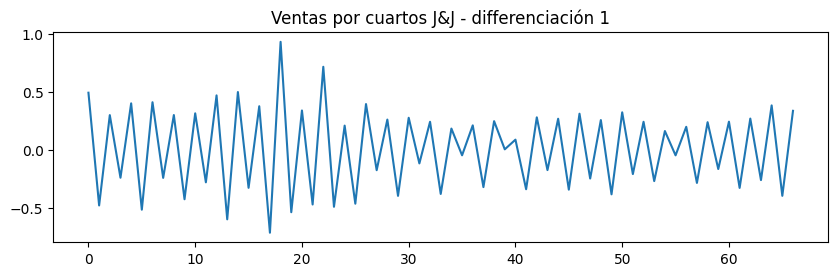

ADF Statistic: -17.852197967191977
p-value: 3.076357231314075e-30


In [98]:
from statsmodels.tsa.stattools import adfuller

# Por experimentación, fue necesario diferenciar 2 veces para poder volver la serie estacionaria.
detrend_ts = np.diff(np.log(dataset['Revenue']), 2)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(detrend_ts)
ax1.set_title("Ventas por cuartos J&J - differenciación 1")
plt.show()

ad_fuller_result = adfuller(detrend_ts)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

Esta es una modificación al algorithmo de optimización donde ahora podemos evaluar no solo parámetros normales sino estacionales.

In [118]:
import tqdm
from typing import Tuple, List
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

def optimizeSARIMA(data: np.ndarray, 
                    orders: List[Tuple[int]],
                    criteria: str = "aic") -> (float, Tuple[int]):

    best_criteria = float("inf")
    best_order = None

    with tqdm.tqdm(total = len(orders)) as progress:
        for order in orders:
            try:
                # el orden recibido es (p, d, q, P, D, Q, s)
                regular = (order[0], order[1], order[2])
                seasonal = (order[3], order[4], order[5], order[6])
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore')
                    model = SARIMAX(data, 
                                    order=regular, 
                                    seasonal_oder=seasonal,
                                    simple_differencing=False
                                    ).fit(disp=False)
                    
                # obtenemos el criterio AIC de estos parámetros
                if criteria == "aic":
                    criteria_val = model.aic
                elif criteria == "bic":
                    criteria_val = model.bic
                if criteria_val < best_criteria:
                    best_criteria = criteria_val
                    best_order = order
            except Exception as e:
                # Configuración inválida de modelo, es seguro ignorar
                continue
            finally:
                progress.update()

    return best_criteria, best_order

## ARIMA
A manera de completitud y comparación, entrenemos primero un modelo ARIMA y evaluemos los resultados.

In [119]:
%%time
from itertools import product

ps = range(8)
d = [2]
qs = range(8)
Ps = [0]
Ds = [0]
Qs = [0]
s = [0]

orders = list(product(ps, d, qs, Ps, Ds, Qs, s))

aic, best_orders = optimizeSARIMA(dataset['Revenue'], orders)
print(20 * "#")
print(f"Los mejores parámetros son: {best_orders}, con un aic de: {aic}")
print(20 * "#")

100%|██████████| 64/64 [00:16<00:00,  3.83it/s]

####################
Los mejores parámetros son: (4, 2, 7, 0, 0, 0, 0), con un aic de: 907.0401101051425
####################
CPU times: user 57.6 s, sys: 52.4 s, total: 1min 50s
Wall time: 16.7 s


/home/ohtar10/miniconda3/envs/icesi-advanced-dl/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ohtar10/miniconda3/envs/icesi-advanced-dl/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                   69
Model:               SARIMAX(4, 2, 7)   Log Likelihood                -441.520
Date:                Sun, 11 Feb 2024   AIC                            907.040
Time:                        15:00:23   BIC                            933.496
Sample:                             0   HQIC                           917.509
                                 - 69                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0640      0.401     -2.651      0.008      -1.851      -0.277
ar.L2         -1.0716      0.410     -2.612      0.009      -1.876      -0.268
ar.L3         -1.0452      0.419     -2.495      0.0

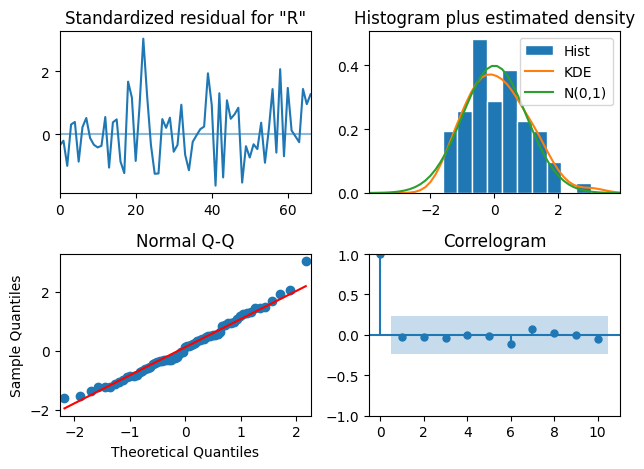

In [81]:
regular = (best_orders[0], best_orders[1], best_orders[2])
best_model = SARIMAX(dataset['Revenue'], order=regular, simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())
res.plot_diagnostics()
plt.tight_layout()
plt.show()

In [82]:
from sklearn.metrics import mean_squared_error

n_forecast = 10
predict = res.get_prediction(end=best_model.nobs + n_forecast)
predictions = predict.predicted_mean

data = pd.DataFrame({'data': dataset['Revenue'], 'predictions': predictions[:-(n_forecast+1)]})
mse = mean_squared_error(data['data'], data['predictions'])
print(f"MSE contra los datos: {mse:.5f}")
data.head(15)

MSE contra los datos: 70647.41631


,data,predictions
0,1517,0.000000
1,1248,1999.055370
2,1677,1958.000906
3,1393,1456.861792
4,1558,1875.772086
5,1368,1300.158679
6,1790,1706.523964
7,1396,1576.318463
8,1638,1591.843842
9,1507,1401.877349


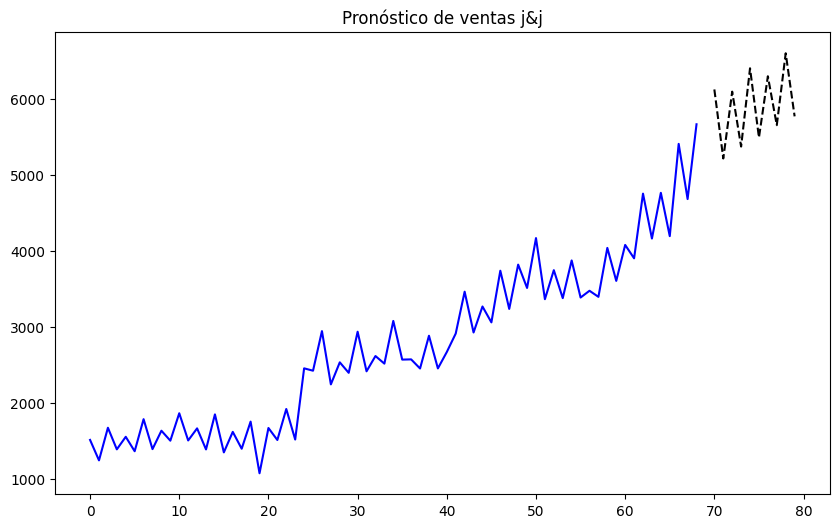

In [84]:
idx = np.arange(len(predict.predicted_mean))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(data['data'], 'blue', label='Serie')
ax.plot(idx[-n_forecast:], predictions[-n_forecast:], 'k--', label='Pronóstico')
ax.set_title('Pronóstico de ventas Adidas')
plt.show()

## SARIMA
Ahora, evaluemos los datos con SARIMA. En primer lugar, sabemos que tenemos un dataset que entrega resultados por cuartos, por lo que deberíamos esperar picos cada 4 meses, esta sería la base para diferenciar y obneter posibles patrónes estacionales.

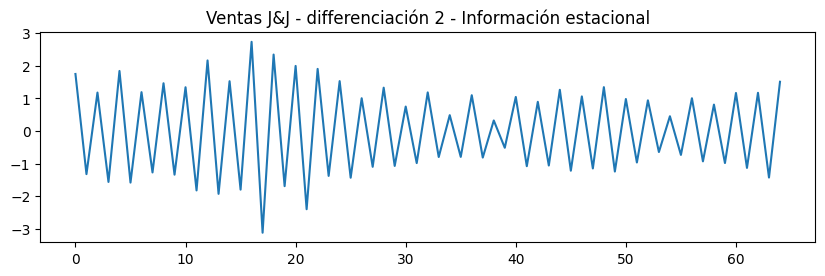

ADF Statistic: -5.90783720288783
p-value: 2.682326539445624e-07


In [101]:
detrend_ts2 = detrend_ts = np.diff(np.log(dataset['Revenue']), n=4)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(detrend_ts2)
ax1.set_title("Ventas J&J - differenciación 2 - Información estacional")
plt.show()

ad_fuller_result = adfuller(detrend_ts2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

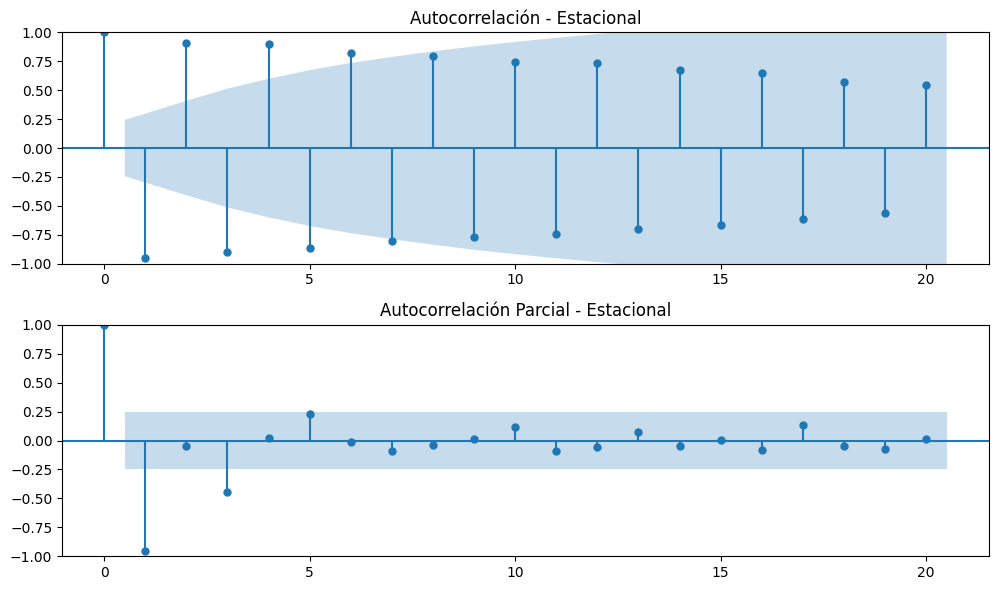

In [103]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
plot_acf(detrend_ts2, lags=20, title="Autocorrelación - Estacional", ax=ax1)
plot_pacf(detrend_ts2, lags=20, title="Autocorrelación Parcial - Estacional", ax=ax2)
plt.tight_layout()
plt.show()

In [93]:
%%time
ps = range(8)
d = [2]
qs = range(8)
Ps = range(4)
Ds = [1]
Qs = range(4)
s = [4]

orders = list(product(ps, d, qs, Ps, Ds, Qs, s))

aic, best_orders = optimizeSARIMA(dataset['Revenue'], orders)
print(20 * "#")
print(f"Los mejores parámetros son: {best_orders}, con un aic de: {aic}")
print(20 * "#")

100%|██████████| 1024/1024 [05:20<00:00,  3.19it/s]

####################
Los mejores parámetros son: (4, 2, 7, 0, 1, 0, 4), con un aic de: 907.0401101051425
####################


Curiosamene, a pesar de que los datos informan sobre ventas por cuartos, según la estimación por AIC, solo basta con diferenciar una vez para capturar la información estacional, entre información estacional, no hay patrones AR y MA con significancia.

/home/ohtar10/miniconda3/envs/icesi-advanced-dl/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                            Revenue   No. Observations:                   69
Model:             SARIMAX(4, 2, 7)x(0, 1, [], 4)   Log Likelihood                -416.281
Date:                            Sun, 11 Feb 2024   AIC                            856.563
Time:                                    15:15:13   BIC                            882.280
Sample:                                         0   HQIC                           866.678
                                             - 69                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7080      0.515     -3.316      0.001      -2.718      -0.698
ar.L2         -1.0169      0.852   

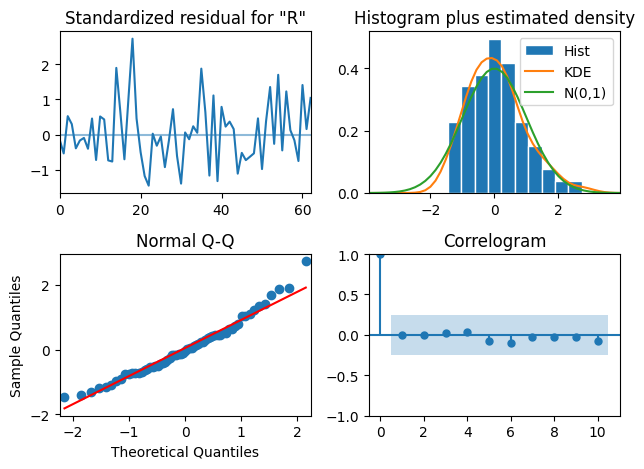

In [94]:
regular = (best_orders[0], best_orders[1], best_orders[2])
seasonal = (best_orders[3], best_orders[4], best_orders[5], best_orders[6])

best_model = SARIMAX(dataset['Revenue'], order=regular, seasonal_order=seasonal, simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())
res.plot_diagnostics()
plt.tight_layout()
plt.show()

MSE contra los datos: 99747.37775


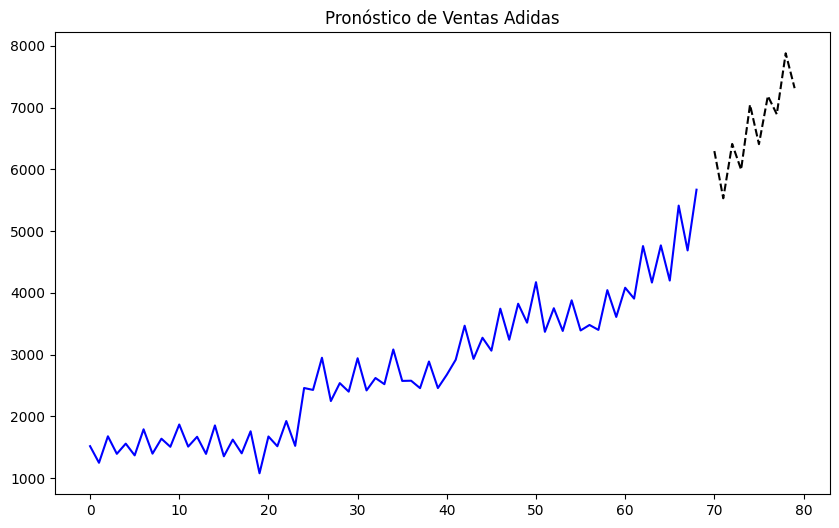

In [105]:
n_forecast = 10
predict = res.get_prediction(end=best_model.nobs + n_forecast)
predictions = predict.predicted_mean

data = pd.DataFrame({'data': dataset['Revenue'], 'predictions': predictions[:-(n_forecast+1)]})
mse = mean_squared_error(data['data'], data['predictions'])
print(f"MSE contra los datos: {mse:.5f}")

idx = np.arange(len(predict.predicted_mean))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(data['data'], 'blue', label='Serie')
ax.plot(idx[-n_forecast:], predictions[-n_forecast:], 'k--', label='Pronóstico')
ax.set_title('Pronóstico de Ventas Adidas')
plt.show()

Nótemos que en terminos de MSE, hemos obtenido un modelo "peor" que un modelo ARIMA simple. Sin embargo, al hacer pronósticos, obtenemos unos resultados un tanto diferentes y quizás optimistas, esto debido a la influencia estacional, que no estaría presente en el modelo ARIMA normal.

En conclusión, es preciso entrenar varios modelos y hacer estimaciones con todos ellos, siempre comparando con la realidad para así ajustar los parámetros según lo observado. A pesar de todo, como ya establecimos anteriormente, estos modelos responden mucho mejor a los patrones de los datos que las regresiones clásicas.

## SARIMAX

Para dar cierre a los modelos clásicos, vamos a explorar $SARIMAX$ que es el mismo $SARIMA$ pero con la capacidad de aceptar variables agenas al dato que queremos predecir pero que pueden contribuir como predictores a esta. Básicamente es como predecir un escalar a partir de un vector en el tiempo.

Cabe aclarar que este método solamente acepta vectores en la ingesta de datos, solo es capaz de predecir un único valor.

Vamos a usar uno de los datasets que vienen junto con la librería statsmodels. Concretamente el dataset de datos macroeconómicos de Estados Unidos. Este dataset contiene Información por cuartos de la evolución del PIB norteamericano desde 1959 hasta 2009.

In [109]:
macro_data = sm.datasets.macrodata.load_pandas().data
macro_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


Primero, podemos observar que más allá del PIB (realgdp), contamos con otros valores en los mismos periodos de tiempo. Cada uno de estos es en si una serie de tiempo, en este caso nos interesa solamente el PIB, pero todos los demás valores pueden tener o no una ingerencia en como evoluciona el PIB, por eso la idea es hacer uso de las demás series.

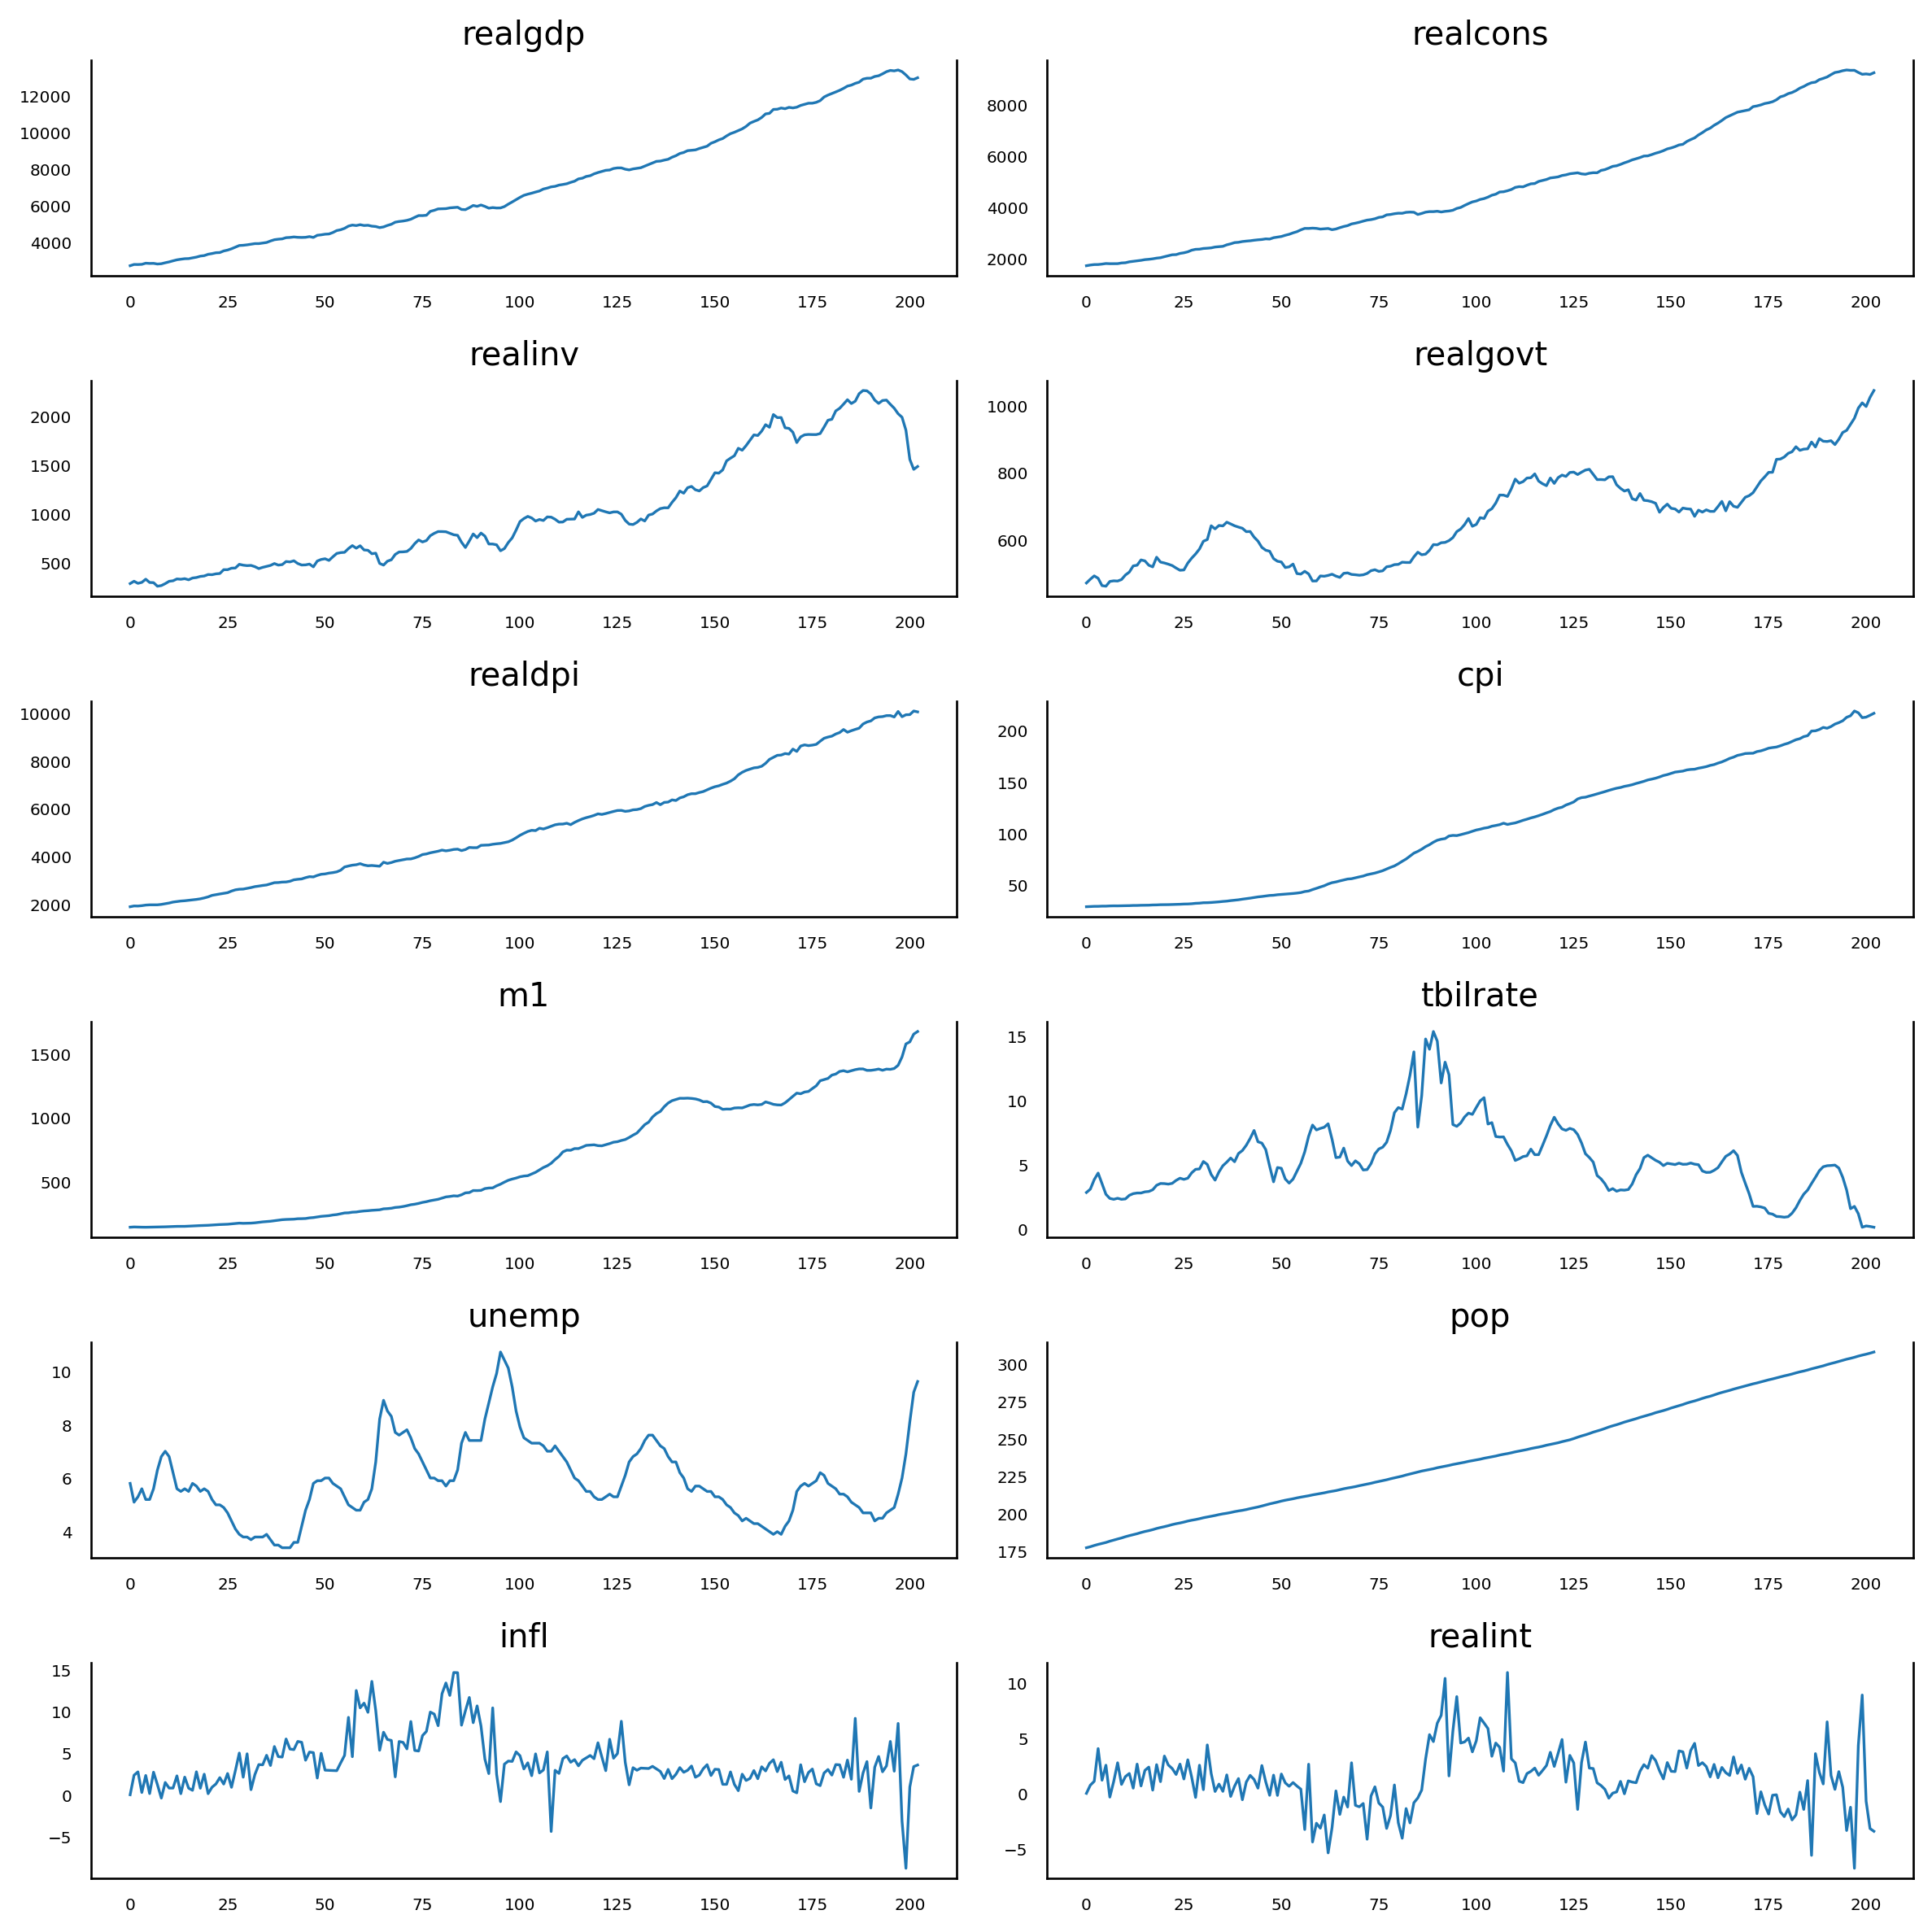

In [110]:
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=240, figsize=(10,10))

for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i+2]]
    
    ax.plot(data, linewidth=1)
    ax.set_title(macro_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

Primero, como hemos notado, el PIB sigue una tendencia, por lo que primero debemos removerla, ya sabemos como.

In [111]:
macro_data['realgdp_diff1'] = macro_data['realgdp'].diff()
macro_data.head(10)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,realgdp_diff1
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00,NaN
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74,68.452
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09,-3.313
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06,9.716
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19,62.495
5,1960.0,2.0,2834.390,1792.9,298.152,460.400,1966.1,29.55,140.2,2.68,5.2,180.671,0.14,2.55,-13.309
6,1960.0,3.0,2839.022,1785.8,296.375,474.676,1967.8,29.75,140.9,2.36,5.6,181.528,2.70,-0.34,4.632
7,1960.0,4.0,2802.616,1788.2,259.764,476.434,1966.6,29.84,141.1,2.29,6.3,182.287,1.21,1.08,-36.406
8,1961.0,1.0,2819.264,1787.7,266.405,475.854,1984.5,29.81,142.1,2.37,6.8,182.992,-0.40,2.77,16.648
9,1961.0,2.0,2872.005,1814.3,286.246,480.328,2014.4,29.92,142.9,2.29,7.0,183.691,1.47,0.81,52.741


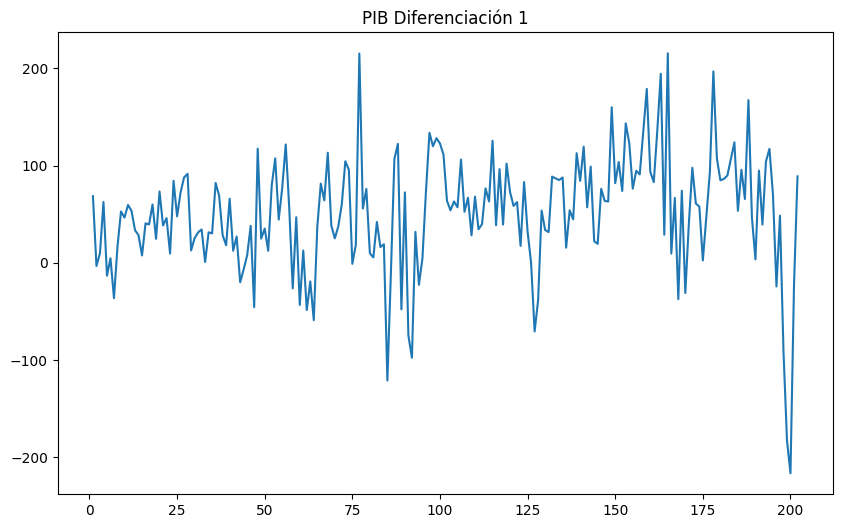

In [112]:
fig = plt.figure(figsize=(10, 6))
plt.plot(macro_data['realgdp_diff1'])
plt.title('PIB Diferenciación 1')
plt.show()

In [114]:
ad_fuller_result = adfuller(macro_data['realgdp_diff1'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08


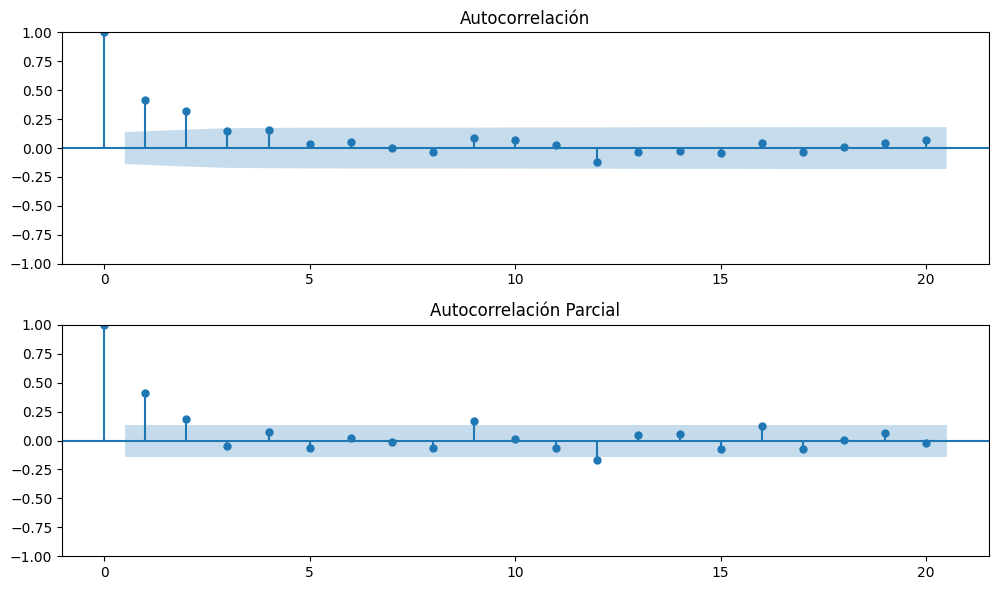

In [117]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
plot_acf(macro_data['realgdp_diff1'][1:], lags=20, title="Autocorrelación", ax=ax1)
plot_pacf(macro_data['realgdp_diff1'][1:], lags=20, title="Autocorrelación Parcial", ax=ax2)
plt.tight_layout()
plt.show()

Ahora, realizamos una modificación más a nuestra función de optimización. Técnicamente, SARIMAX es el mismo SARIMAX pero donde podemos pasar datos adicionales. Es esto justo lo que vamos a hacer.

In [122]:
def optimizeSARIMAX(endog: np.ndarray,
                    exog: np.ndarray, 
                    orders: List[Tuple[int]],
                    criteria: str = "aic") -> (float, Tuple[int]):

    best_criteria = float("inf")
    best_order = None

    with tqdm.tqdm(total = len(orders)) as progress:
        for order in orders:
            try:
                # el orden recibido es (p, d, q, P, D, Q, s)
                regular = (order[0], order[1], order[2])
                seasonal = (order[3], order[4], order[5], order[6])
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore')
                    # Aquí pasamos información exógena, i.e., otras series.
                    model = SARIMAX(endog,
                                    exog, 
                                    order=regular, 
                                    seasonal_oder=seasonal,
                                    simple_differencing=False
                                    ).fit(disp=False)
                    
                # obtenemos el criterio AIC de estos parámetros
                if criteria == "aic":
                    criteria_val = model.aic
                elif criteria == "bic":
                    criteria_val = model.bic
                if criteria_val < best_criteria:
                    best_criteria = criteria_val
                    best_order = order
            except Exception as e:
                # Configuración inválida de modelo, es seguro ignorar
                continue
            finally:
                progress.update()

    return best_criteria, best_order

Y procedemos a hallar los ordenes óptimos.

In [139]:
%%time

ps = range(8)
d = [1]
qs = range(8)

Ps = range(4)
Ds = [0]
Qs = range(4)
s = [4]

orders = list(product(ps, d, qs, Ps, Ds, Qs, s))

endog = macro_data['realgdp'][:200]
exog = macro_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']][:200]

aic, best_orders = optimizeSARIMAX(endog, exog, orders)
print(20 * "#")
print(f"Los mejores parámetros son: {best_orders}, con un aic de: {aic}")
print(20 * "#")

100%|██████████| 1024/1024 [19:06<00:00,  1.12s/it]

####################
Los mejores parámetros son: (4, 1, 4, 0, 0, 0, 4), con un aic de: 1756.2087295543297
####################
CPU times: user 1h 1min 6s, sys: 56min 51s, total: 1h 57min 57s
Wall time: 19min 6s


                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(4, 1, 4)   Log Likelihood                -858.104
Date:                Sun, 11 Feb 2024   AIC                           1756.209
Time:                        16:43:08   BIC                           1822.075
Sample:                             0   HQIC                          1782.866
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9109      0.055     16.435      0.000       0.802       1.020
realinv        0.9772      0.044     22.066      0.000       0.890       1.064
realgovt       0.7042      0.136      5.188      0.0

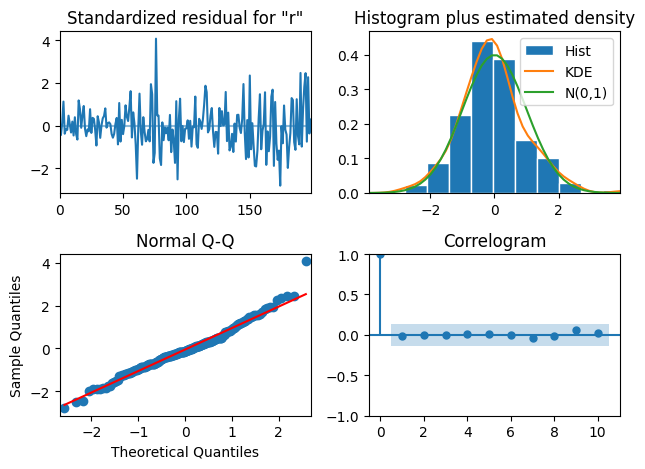

In [141]:
regular = (best_orders[0], best_orders[1], best_orders[2])
seasonal = (best_orders[3], best_orders[4], best_orders[5], best_orders[6])

best_model = SARIMAX(endog, exog, order=regular, seasonal_order=seasonal, simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())
res.plot_diagnostics()
plt.tight_layout()
plt.show()

Algo interesante que podemos observar es que aquí tenemos algunas series cuya contribución no es estadísticamente significativa (ver los $p-valor \geq 0.05$). Podemos optar por simplemente retirarlos de la información exógena y volver a entrenar el modelo. Para efectos demostrativos, los vamos a conservar pues a juzgar por los resultados de los resoduales, el modelo es lo suficientemente bueno.

Finalmente, harémos unas predicciones.

MSE contra los datos: 3659.88520


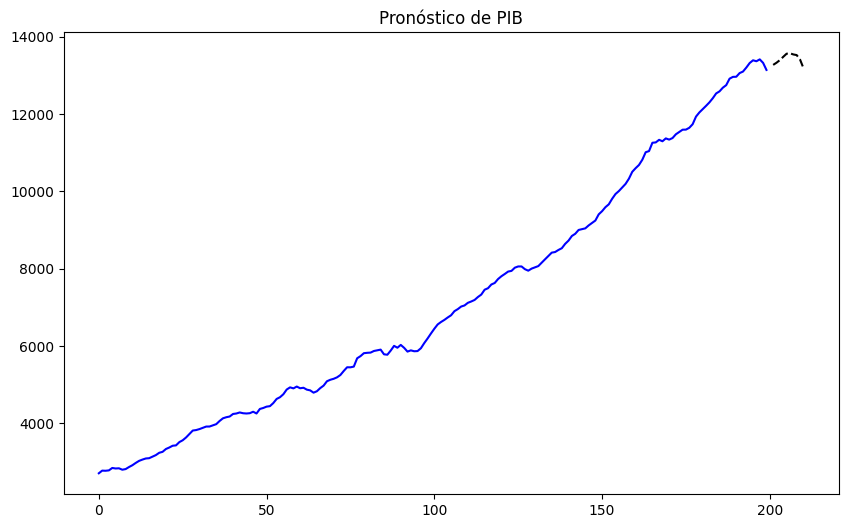

In [153]:
n_forecast = 10
# Vamos a pronosticar 10 pasos adelante, por lo que debemos pasar
# la información exógena de 10 pasos en adelante.
predict = res.get_prediction(end=best_model.nobs + n_forecast, exog=exog.iloc[-11:])
predictions = predict.predicted_mean

data = pd.DataFrame({'data': macro_data['realgdp'], 'predictions': predictions[:-(n_forecast+1)]})
data = data.dropna()

mse = mean_squared_error(data['data'], data['predictions'])
print(f"MSE contra los datos: {mse:.5f}")

idx = np.arange(len(predict.predicted_mean))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(data['data'], 'blue', label='Serie')
ax.plot(idx[-n_forecast:], predictions[-n_forecast:], 'k--', label='Pronóstico')
ax.set_title('Pronóstico de PIB')
plt.show()

En conclusión, $SARIMAX$ es un modelo muy poderoso y que sirve en una variedad de ocasiones, pero no en todas y no siempre es óptimo entrenarlo. Por ejemplo, empezamos a notar que a medida que el volumen de los datos crece y la complejidad de los mismos aumenta, entrenar el modelo es más dispendioso. Ahora imaginemonos una situación donde la dimensionalidad de los datos va mas allá de una o dos dimensiones.

A partir de la siguiente lección ahora si vamos a empezar a ver los modelos de deep learning aplicables a series de tiempo, donde otro arsenal de herramientas nos preparará para lidiar con problemas y datos secuenciales.